In [2]:
using JuMP, Ipopt, SparseArrays, LinearAlgebra, NamedArrays, DelimitedFiles, CSV, DataFrames, Statistics, PyPlot

# Include necessary functions
include("Functions/Ybus.jl");         # Function to calculate Ybus matrix (G,B)
include("Functions/Conventional.jl");   # Function to define constraints (polar)
include("Functions/Cost.jl");          # Function to define cost (polar)
include("Functions/Misc.jl");                # Function to define start point,map input,print output
include("Functions/Parse_gld_1day.jl");      # Function to parse GridLabD system data
include("Functions/Fixed_point.jl");     # Function to implement fixed-point method (polar)
include("Functions/BFS.jl");             # Function to implement BFS method (polar)

# Load test case
global case_name = "case13_glm" 
#global case_name = "GC-12.47-1" 
# global case_name = "R1-12.47-1"  
#global case_name = "turkey_solar"
data_file = open(string("data/",case_name,"/data.xml")); data = readlines(data_file)
z_file = open(string("data/",case_name,"/z_dump.xml")); z_dump = readlines(z_file)
global PV_en = 1;   # 0-exclude, 1-include ZIP loads/PV inverters
    if PV_en == 1
        house_sch = CSV.read(string("House_",case_name,"_profile.csv"),header=false,type=Float64,DataFrame)
        global house_sch = convert(Matrix,house_sch);
        PV_sch = CSV.read(string("PV_",case_name,"_profile.csv"),header=false,type=Float64,DataFrame)
        global PV_sch = convert(Matrix,PV_sch);
    end
# global VUF_init = readdlm(string("VUF_",case_name,"_init.csv"), ',')/100
# global QgY_init = readdlm(string("QgY0_",case_name,"_base.csv"), ',');
# global QgY_init = readdlm("QgY0_R1-12.47-1_freq60_delay60.csv", ',');

## Other inputs
global n_sch = 1440; 
global count_sch = 1;  # Time instant to run OPF
global obj_op=2
# global crit_node = ["n632"]
# global crit_node = ["R1-12-47-1_node_359"]
# global crit_node = ["R1-12-47-3_node_1"]
global crit_node = "all"
global PV_rat = 0.035;
global Q_pen = 0*1e-5; global ΔV_pen = 0*1e-2;
        
## Parse system data
parse_gld(crit_node); global M = 1e3

house_sch = CSV.read(string("Load_schedule_PS1.csv"),header=false,type=Float64,DataFrame)
    global house_sch = convert(Matrix,house_sch)/1e3;
    global n_house_row = size(house_sch,1); global n_house_col = size(house_sch,2)
    PV_sch = CSV.read(string("PV_schedule_PS1.csv"),header=false,type=Float64,DataFrame)
    global PV_sch = convert(Matrix,PV_sch)/1e3; global n_PV_col = size(PV_sch,2)
    

par_det = 8×1 Named Adjoint{Int64,Array{Int64,2}}
Par ╲ Val │ :Value
──────────┼───────
nb        │     30
ngy       │     76
nly       │     80
nld       │      3
nb_nph    │     53
ngy_nph   │     78
nly_nph   │     87
nld_nph   │      7
-------------------


34

In [50]:
house_sch = CSV.read(string("Load_schedule_PS1.csv"),header=false,type=Float64,DataFrame)
global house_sch = convert(Matrix,house_sch)/1e3;
global n_house_row = size(house_sch,1); global n_house_col = size(house_sch,2)
global r1_house_PV = rand(1:n_sch:n_house_row); 
global r2_house = rand(1:n_house_col,15)
 global house_prof =house_sch[r1_house_PV:r1_house_PV+n_sch,r2_house]';
#     writedlm(string("House_",case_name,"_profile1.csv"),10*house_prof , ',');



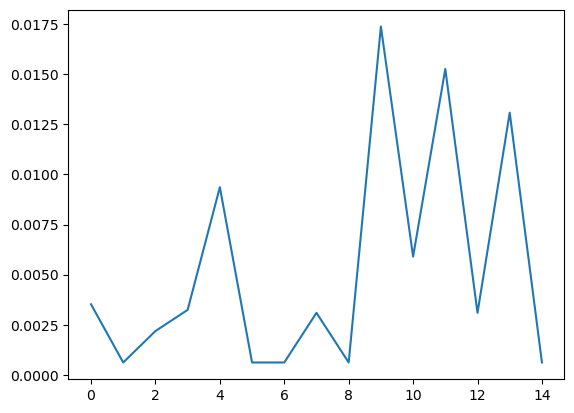

In [53]:
plot(20*house_prof[:,935])
writedlm(string("House_",case_name,"_profile1.csv"),20*house_prof , ',');

In [3]:
## PARSE BUS DATA
    idx_node_f = findall(idx -> idx == "\t\t\t<node>", data); idx_node_t = findall(idx -> idx == "\t\t\t</node>", data)
    idx_load_f = findall(idx -> idx == "\t\t\t<load>", data); idx_load_t = findall(idx -> idx == "\t\t\t</load>", data)
    idx_tnode_f = findall(idx -> idx == "\t\t\t<triplex_node>", data); idx_tnode_t = findall(idx -> idx == "\t\t\t</triplex_node>", data)
    idx_meter_f = findall(idx -> idx == "\t\t\t<meter>", data); idx_meter_t = findall(idx -> idx == "\t\t\t</meter>", data)
    idx_tmeter_f = findall(idx -> idx == "\t\t\t<triplex_meter>", data); idx_tmeter_t = findall(idx -> idx == "\t\t\t</triplex_meter>", data)
    idx_TXL_f = findall(idx -> idx == "\t<triplex_line>", z_dump); idx_TXL_t = findall(idx -> idx == "\t</triplex_line>", z_dump)
    nbr_txl = length(idx_TXL_f)
    idx_bus_f = [idx_node_f; idx_load_f; idx_tnode_f; idx_tmeter_f]; idx_bus_t = [idx_node_t; idx_load_t; idx_tnode_t; idx_tmeter_t]

    ## Calculate total number of nodes
    nb_n = length(idx_node_f); nb_l = length(idx_load_f); nb_tn = length(idx_tnode_f);
    nb_m = length(idx_meter_f); nb_tm = length(idx_tmeter_f);
    global nb = nb_n+nb_l+nb_tn+nb_tm

    ## Create bus_ID matrix to map node-names to node-numbers
    bus_ID_nn = get_data(data,nb_n,idx_node_f,idx_node_t,"<name>",3)
    bus_ID_np = get_data(data,nb_n,idx_node_f,idx_node_t,"<parent>",3)
    bus_ID_ln = get_data(data,nb_l,idx_load_f,idx_load_t,"<name>",3)
    bus_ID_lp = get_data(data,nb_l,idx_load_f,idx_load_t,"<parent>",3)
    bus_ID_tnn = get_data(data,nb_tn,idx_tnode_f,idx_tnode_t,"<name>",3)
    bus_ID_tnp = get_data(data,nb_tn,idx_tnode_f,idx_tnode_t,"<parent>",3)
    bus_ID_mn = get_data(data,nb_m,idx_meter_f,idx_meter_t,"<name>",3)
    bus_ID_mp = get_data(data,nb_m,idx_meter_f,idx_meter_t,"<parent>",3)
    bus_ID_tmn = get_data(data,nb_tm,idx_tmeter_f,idx_tmeter_t,"<name>",3)
    bus_ID_tmp = get_data(data,nb_tm,idx_tmeter_f,idx_tmeter_t,"<parent>",3)
    bus_ID_nam = [bus_ID_nn; bus_ID_ln; bus_ID_tnn; bus_ID_tmn]; bus_ID_par = [bus_ID_np; bus_ID_lp; bus_ID_tnp; bus_ID_tmp];
    global bus_ID = bus_ID_nam;
    bus_type = get_data(data,nb,idx_bus_f,idx_bus_t,"<bustype>",3)

    ## Impose minimum & maximum voltage constraints
    global bus_ph = get_data(data,nb,idx_bus_f,idx_bus_t,"<phases>",3)
    global nb_nph = 0
    for i=1:nb
        dum1 = length(split(split(bus_ph[i],r"S|D|N")[1],""))
        nb_nph = nb_nph + dum1
    end
    global bus_ϕ = repeat(["0"],nb_nph); global bus_count = zeros(nb)
    num_count=1
    for i=1:nb
        dum1 = split(split(bus_ph[i],r"S|D|N")[1],"")
        bus_count[i] = length(dum1)
        bus_ϕ[num_count:num_count+Int(bus_count[i])-1] = dum1
        num_count = Int(num_count+bus_count[i])
    end
    global bus_name = repeat(["0"],nb_nph); num_count = 1
    for i=1:nb
        for j=Int.(sum(bus_count[1:i-1])+1:sum(bus_count[1:i]))
            bus_name[num_count] = string(num_count,":",bus_ID[i],"::",bus_ϕ[j])
            num_count = num_count + 1
        end
    end
    V_min = ones(nb,3)*0.9; V_max = ones(nb,3)*1.1; global nbD_nph = 0
    for i=1:nb
        if bus_ph[i] == "AN" || bus_ph[i] == "AS" || bus_ph[i] == "A"
            V_min[i,2:3] .= 0;   V_max[i,2:3] .= 0;
        elseif bus_ph[i] == "BN" || bus_ph[i] == "BS" || bus_ph[i] == "B"
            V_min[i,1:2:3] .= 0; V_max[i,1:2:3] .= 0;
        elseif bus_ph[i] == "CN" || bus_ph[i] == "CS" || bus_ph[i] == "C"
            V_min[i,1:2] .= 0;   V_max[i,1:2] .= 0;
        elseif bus_ph[i] == "ABN" || bus_ph[i] == "ABD" || bus_ph[i] == "BAN" || bus_ph[i] == "BAD" || bus_ph[i] == "BA" || bus_ph[i] == "AB"
            V_min[i,3] = 0;      V_max[i,3] = 0;  nbD_nph = nbD_nph+1
        elseif bus_ph[i] == "BCN" || bus_ph[i] == "BCD" || bus_ph[i] == "CBN"  || bus_ph[i] == "CBD" || bus_ph[i] == "CB" || bus_ph[i] == "BC"
            V_min[i,1] = 0;      V_max[i,1] = 0;  nbD_nph = nbD_nph+1
        elseif bus_ph[i] == "ACN" || bus_ph[i] == "ACD" || bus_ph[i] == "CAN" || bus_ph[i] == "CAD" || bus_ph[i] == "CA" || bus_ph[i] == "AC"
            V_min[i,2] = 0;      V_max[i,2] = 0;  nbD_nph = nbD_nph+1
        else
            nbD_nph = nbD_nph+3
        end
    end

    ## Read current powerflow solution from GridLabD (warm-start)
    global bus_Vnom = str_num(get_data(data,nb,idx_bus_f,idx_bus_t,"<nominal_voltage>",3))
    for i=1:nb
        if bus_Vnom[i] == 480
           bus_Vnom[i] = 480/sqrt(3)
        end
    end
    p2n = ["A" "B" "C"]; l2l = ["AB" "BC" "CA"];
    global s0 = spzeros(nb,6);
    for i=1:3
        s0[1:nb_n+nb_l,2*i-1:2*i] = warm_start(get_data(data,nb_n+nb_l,[idx_node_f; idx_load_f],[idx_node_t; idx_load_t],string("<voltage_",p2n[i],">"),3))
    end
    if nbr_txl != 0
        dum1 = warm_start(get_data(data,nb_tn,idx_tnode_f,idx_tnode_t,string("<voltage_1>"),3))
        for i=1:nb_tn
            if dum1[i,2] >= -60 && dum1[i,2] <= 60
                s0[nb_n+nb_l+i,1:2] = dum1[i,:]
            elseif dum1[i,2] >= -180 && dum1[i,2] <= -60
                s0[nb_n+nb_l+i,3:4] = dum1[i,:]
            elseif dum1[i,2] >= 60 && dum1[i,2] <= 180
                s0[nb_n+nb_l+i,5:6] = dum1[i,:]
            end
        end
    else
        dum1 = warm_start(get_data(data,nb_tm,idx_tmeter_f,idx_tmeter_t,string("<voltage_1>"),3))
        for i=1:nb_tm
            if dum1[i,2] >= -60 && dum1[i,2] <= 60
                s0[nb_n+nb_l+i,1:2] = dum1[i,:]
            elseif dum1[i,2] >= -180 && dum1[i,2] <= -60
                s0[nb_n+nb_l+i,3:4] = dum1[i,:]
            elseif dum1[i,2] >= 60 && dum1[i,2] <= 180
                s0[nb_n+nb_l+i,5:6] = dum1[i,:]
            end
        end
    end
    s0[:,1:2:5] = s0[:,1:2:5]./ [bus_Vnom bus_Vnom bus_Vnom]

    ## Create bus matrix
    global bus = zeros(nb,14)
    bus[:,1] = 1:nb
    for i=1:nb
        if bus_type[i] == "SWING"
            bus[i,2] = 3
        elseif bus_type[i] == "PV"
            bus[i,2] = 2
        elseif bus_type[i] == "PQ"
            bus[i,2] = 1
        end
    end
    bus[:,3:2:7] = V_min
    bus[:,4:2:8] = V_max
    bus[:,9:14] = s0;

    ## Update bus matrix by removing redundant nodes
    global bus_ref = findfirst(idx->idx==3,bus[:,2]);
    nb_red = 0
    for i=1:nb
        dum1=findall(idx -> idx != bus_ID[bus_ref] && idx == bus_ID_nam[i], bus_ID_par)
        nb_red = nb_red + length(dum1)
    end
    bus_red = zeros(nb_red); num_count = 1
    for i=1:nb
        dum1=findall(idx -> idx != bus_ID[bus_ref] && idx == bus_ID_nam[i], bus_ID_par)
        bus_red[num_count:num_count+length(dum1)-1] = dum1
        num_count = num_count + length(dum1)
    end
    bus_new = zeros(nb-nb_red,14); num_count = 1; global nb_nph = 0
    for i=1:nb
        if isempty(findall(idx -> idx == i, bus_red))
            bus_new[num_count,:] = bus[i,:]
            num_count = num_count+1
            dum1 = length(split(split(bus_ph[i],r"S|D|N")[1],""))
            nb_nph = nb_nph + dum1
        end
    end
    bus = bus_new; nb = nb-nb_red;
    bus_idx = Int.(bus[:,1]); bus[:,1] = 1:nb
    bus_type = bus_type[bus_idx]
    bus_ID = bus_ID[bus_idx]; bus_ph = bus_ph[bus_idx]
    bus_Vnom = bus_Vnom[bus_idx];
    bus_ID_nam = bus_ID_nam[bus_idx]; bus_ID_par = bus_ID_par[bus_idx];
    global bus_ϕ = repeat(["0"],nb_nph); global bus_count = zeros(nb)
    num_count=1
    for i=1:nb
        dum1 = split(split(bus_ph[i],r"S|D|N")[1],"")
        bus_count[i] = length(dum1)
        bus_ϕ[num_count:num_count+Int(bus_count[i])-1] = dum1
        num_count = Int(num_count+bus_count[i])
    end
    global bus_name = repeat(["0"],nb_nph); num_count = 1
    for i=1:nb
        for j=Int.(sum(bus_count[1:i-1])+1:sum(bus_count[1:i]))
            bus_name[num_count] = string(num_count,":",bus_ID[i],"::",bus_ϕ[j])
            num_count = num_count + 1
        end
    end

    ## Calculate three-phase nodes
    global idx_bus_3ph = findall(idx -> idx == 3,bus_count)
    global nb_3ph = length(idx_bus_3ph);
    if crit_node == "All" || crit_node == "all" || crit_node == "ALL"
        crit_node = bus_ID[idx_bus_3ph]
    end
    global n_VU = length(crit_node);
    global bus_target = zeros(n_VU)
    for i=1:length(crit_node)
        bus_target[i] = findfirst(idx -> idx == crit_node[i], bus_ID)
    end
    global idx_bus_3ph1 = spzeros(n_VU*3)
    for i=1:n_VU
        j = Int(bus_target[i])
        idx_bus_3ph1[i*3-2:i*3] = sum(bus_count[1:j-1])+1:sum(bus_count[1:j])
    end
    global idx_bus_3ph2 = spzeros(nb_3ph*3)
    for i=1:nb_3ph
        j = Int(idx_bus_3ph[i])
        idx_bus_3ph2[i*3-2:i*3] = sum(bus_count[1:j-1])+1:sum(bus_count[1:j])
    end

In [4]:
## PARSE BRANCH DATA
    idx_OHL_f = findall(idx -> idx == "\t<overhead_line>", z_dump); idx_OHL_t = findall(idx -> idx == "\t</overhead_line>", z_dump)
    idx_UGL_f = findall(idx -> idx == "\t<underground_line>", z_dump); idx_UGL_t = findall(idx -> idx == "\t</underground_line>", z_dump)
    idx_TF_f = findall(idx -> idx == "\t<transformer>", z_dump); idx_TF_t = findall(idx -> idx == "\t</transformer>", z_dump)
    idx_VR_f = findall(idx -> idx == "\t<regulator>", z_dump); idx_VR_t = findall(idx -> idx == "\t</regulator>", z_dump)
    idx_SW_f = findall(idx -> idx == "\t<switch>", z_dump); idx_SW_t = findall(idx -> idx == "\t</switch>", z_dump)
    idx_FS_f = findall(idx -> idx == "\t<fuse>", z_dump); idx_FS_t = findall(idx -> idx == "\t</fuse>", z_dump)
    idx_TXL_f = findall(idx -> idx == "\t<triplex_line>", z_dump); idx_TXL_t = findall(idx -> idx == "\t</triplex_line>", z_dump)
    idx_branch_f = [idx_OHL_f; idx_UGL_f; idx_TF_f; idx_VR_f; idx_SW_f; idx_FS_f; idx_TXL_f]
    idx_branch_t = [idx_OHL_t; idx_UGL_t; idx_TF_t; idx_VR_t; idx_SW_t; idx_FS_t; idx_TXL_t]

    ## Calculate total number of branches (includes overhead, triplex & underground lines, transformers, regulators, switch, fuse)
    nbr_ohl = length(idx_OHL_f); nbr_ugl = length(idx_UGL_f); nbr_tf = length(idx_TF_f);
    nbr_vr = length(idx_VR_f);  nbr_sw = length(idx_SW_f);  nbr_fs = length(idx_FS_f);
    nbr_txl = length(idx_TXL_f);
    global nbr = nbr_ohl+nbr_ugl+nbr_tf+nbr_vr+nbr_sw+nbr_fs+nbr_txl
    global ntf = nbr_tf+nbr_vr

    ## Read all transformers/regulators configurations from GridLabD
    idx_TF_cfig_f = findall(idx -> idx == "\t\t\t<transformer_configuration>", data); idx_TF_cfig_t = findall(idx -> idx == "\t\t\t</transformer_configuration>", data)
    ntf_config = length(idx_TF_cfig_f)
    TF_cfig_name = get_data(data,ntf_config,idx_TF_cfig_f,idx_TF_cfig_t,"<name>",4)
    TF_cfig_type = get_data(data,ntf_config,idx_TF_cfig_f,idx_TF_cfig_t,"<connect_type>",3)
    TF_cfig_Vpri = str_num(get_data(data,ntf_config,idx_TF_cfig_f,idx_TF_cfig_t,"<primary_voltage>",3))
    TF_cfig_Vsec = str_num(get_data(data,ntf_config,idx_TF_cfig_f,idx_TF_cfig_t,"<secondary_voltage>",3))
    TF_cfig_kVA = str_num(get_data(data,ntf_config,idx_TF_cfig_f,idx_TF_cfig_t,"<power_rating>",3))
    TF_config = [TF_cfig_name TF_cfig_type TF_cfig_Vpri TF_cfig_Vsec TF_cfig_kVA]
    idx_VR_cfig_f = findall(idx -> idx == "\t\t\t<regulator_configuration>", data); idx_VR_cfig_t = findall(idx -> idx == "\t\t\t</regulator_configuration>", data)
    nvr_config = length(idx_VR_cfig_f)
    VR_cfig_name = get_data(data,nvr_config,idx_VR_cfig_f,idx_VR_cfig_t,"<name>",4)
    VR_cfig_bc = str_num(get_data(data,nvr_config,idx_VR_cfig_f,idx_VR_cfig_t,"<band_center>",3))
    VR_cfig_bw = str_num(get_data(data,nvr_config,idx_VR_cfig_f,idx_VR_cfig_t,"<band_width>",3))
    VR_cfig_pt = str_num(get_data(data,nvr_config,idx_VR_cfig_f,idx_VR_cfig_t,"<power_transducer_ratio>",3))
    global VR_config = [VR_cfig_name VR_cfig_pt VR_cfig_bc-VR_cfig_bw/2 VR_cfig_bc+VR_cfig_bw/2]

    ## Calculate base values
    tf_rating = get_data(z_dump,nbr_tf,idx_TF_f,idx_TF_t,"<power_rating>",3)
    TF_ph = get_data(z_dump,nbr_tf,idx_TF_f,idx_TF_t,"<phases>",3)
    tf_rat = zeros(nbr_tf)
    for i=1:nbr_tf
        if TF_ph[i] == "ABCN" || TF_ph[i] == "ABC"
            tf_rat[i] = parse(Float64,tf_rating[i])/3e3
        else
            tf_rat[i] = parse(Float64,tf_rating[i])/1e3
        end
    end
    if nbr_tf != 0
        global baseMVA = findmax(tf_rat)[1]
    else
        global baseMVA = 1
    end
    global baseZ= bus_Vnom.^2*1e-6/baseMVA;
    global baseI = baseMVA*1e6/bus_Vnom;

    ## Create matrix for switch status
    idx_SW_f1 = findall(idx -> idx == "\t\t\t<switch>", data); idx_SW_t1 = findall(idx -> idx == "\t\t\t</switch>", data)
    SW_ph = get_data(data,nbr_sw,idx_SW_f1,idx_SW_t1,"<phases>",3)
    SW_ph_sts = spzeros(nbr_sw,3)
    for i=1:nbr_sw
        if occursin("A",SW_ph[i])
            SW_ph_sts[i,1] = 1
        end
        if occursin("B",SW_ph[i])
            SW_ph_sts[i,2] = 1
        end
        if occursin("C",SW_ph[i])
            SW_ph_sts[i,3] = 1
        end
    end
    SW_sts = spzeros(nbr_sw,3)
    for i=1:3
        dum1 = get_data(data,nbr_sw,idx_SW_f1,idx_SW_t1,string("<phase_",p2n[i],"_state>"),3)
        for j=1:nbr_sw
            if dum1[j] == "CLOSED" && SW_ph_sts[j,i] == 1
                SW_sts[j,i] = 1
            end
        end
    end

    ## Create matrix for fuse status
    idx_FS_f1 = findall(idx -> idx == "\t\t\t<fuse>", data); idx_FS_t1 = findall(idx -> idx == "\t\t\t</fuse>", data)
    FS_cur_lim = str_num(get_data(data,nbr_fs,idx_FS_f1,idx_FS_t1,"<current_limit>",3))
    FS_ph = get_data(data,nbr_fs,idx_FS_f1,idx_FS_t1,"<phases>",3)
    FS_ph_sts = spzeros(nbr_fs,3)
    for i=1:nbr_fs
        if occursin("A",FS_ph[i])
            FS_ph_sts[i,1] = 1
        end
        if occursin("B",FS_ph[i])
            FS_ph_sts[i,2] = 1
        end
        if occursin("C",FS_ph[i])
            FS_ph_sts[i,3] = 1
        end
    end
    FS_sts = spzeros(nbr_fs,3)
    for i=1:3
        dum1 = get_data(data,nbr_fs,idx_FS_f1,idx_FS_t1,string("<phase_",p2n[i],"_status>"),3)
        for j=1:nbr_fs
            if dum1[j] == "GOOD" && FS_ph_sts[j,i] == 1
                FS_sts[j,i] = 1
            end
        end
    end
    SW_FS_sts = [SW_sts; FS_sts]

    ## Create branch matrix
    global branch = zeros(nbr,23); global tf_branch = zeros(nbr,8); global nbr_nph = 0;
    branch_ID_f = get_data(z_dump,nbr,idx_branch_f,idx_branch_t,"<from_node>",4)
    branch_ID_t = get_data(z_dump,nbr,idx_branch_f,idx_branch_t,"<to_node>",4)
    TXL_ph = get_data(z_dump,nbr_txl,idx_TXL_f,idx_TXL_t,"<phases>",3)
    idx_a_f = findall(idx -> idx == "\t\t<a_matrix>", z_dump); idx_b_f = findall(idx -> idx == "\t\t<b_matrix>", z_dump);
    a_mat = zeros(3,3)*(0+0*im); b_mat = zeros(3,3)*(0+0*im);
    for i=1:nbr
        if isempty(findall(idx_f -> idx_f == branch_ID_f[i], bus_ID_nam))
            branch[i,1] = findfirst(idx_f -> idx_f == branch_ID_f[i], bus_ID_par)[1]
        else
            branch[i,1] = findfirst(idx_f -> idx_f == branch_ID_f[i], bus_ID_nam)[1]
        end
        if isempty(findall(idx_t -> idx_t == branch_ID_t[i], bus_ID_nam))
            branch[i,2] = findfirst(idx_t -> idx_t == branch_ID_t[i], bus_ID_par)[1]
        else
            branch[i,2] = findfirst(idx_t -> idx_t == branch_ID_t[i], bus_ID_nam)[1]
        end
        nbr_nph = Int(nbr_nph+ findmin([bus_count[Int(branch[i,1])] bus_count[Int(branch[i,2])]])[1]);
        for j=1:nbr
            if (idx_a_f[j] > idx_branch_f[i]) && (idx_a_f[j] < idx_branch_t[i])
                a_mat = branch_matrix(z_dump,idx_a_f[j])
                b_mat = branch_matrix(z_dump,idx_b_f[j])
            end
        end
        if (i > nbr_ohl+nbr_ugl+nbr_tf+nbr_vr) && (i <= nbr-nbr_txl)
            b_mat = zeros(3,3)*(1+1*im)
            for k=1:3
                b_mat[k,k] = 0.00001*SW_FS_sts[i-(nbr_ohl+nbr_ugl+nbr_tf+nbr_vr),k]*(1+0*im)*(bus_Vnom[Int(branch[i,1])]/1e3)^2/baseMVA
            end
        end
        if (i > nbr-nbr_txl)
            b1 = b_mat[1,1]; b2 = b_mat[1,2];
            b_mat = zeros(3,3)*(1+1*im)
            if TXL_ph[i-nbr+nbr_txl] == "AS"
                b_mat[1,1] = b1
            elseif TXL_ph[i-nbr+nbr_txl] == "BS"
                b_mat[2,2] = b1
            else
                b_mat[3,3] = b1
            end
       end
       branch[i,3:17] = branch_parse(a_mat,b_mat,bus_Vnom[Int(branch[i,1])])
    end
    branch[nbr-nbr_txl-nbr_fs+1:nbr-nbr_txl,18] = bus_Vnom[Int.(branch[nbr-nbr_txl-nbr_fs+1:nbr-nbr_txl,1])].*FS_cur_lim/1e6
    branch[:,21] .= -60
    branch[:,22] .= 60
    branch[:,23] .= 1

    ## Create tf_branch matrix
    if nbr_tf != 0 || nbr_vr != 0
        tf_branch[:,1:2] = branch[:,1:2]
        tf_branch[:,3] = [zeros(nbr_ohl+nbr_ugl); ones(nbr_tf); ones(nbr_vr)*8; zeros(nbr_sw+nbr_fs+nbr_txl)]
        tf_res = get_data(z_dump,nbr_tf,idx_TF_f,idx_TF_t,"<resistance>",3)
        tf_reac = get_data(z_dump,nbr_tf,idx_TF_f,idx_TF_t,"<reactance>",3)
        idx_TF_f1 = findall(idx -> idx == "\t\t\t<transformer>", data); idx_TF_t1 = findall(idx -> idx == "\t\t\t</transformer>", data)
        tf_confg = get_data(data,nbr_tf,idx_TF_f1,idx_TF_t1,"<configuration>",4)
        count1=1
        for i=nbr_ohl+nbr_ugl+1:nbr_ohl+nbr_ugl+nbr_tf
            tf_cfg_idx = findfirst(idx -> idx == tf_confg[count1], TF_config[:,1])
            tf_branch[i,4] = parse(Float64,tf_res[count1])*baseMVA/tf_rat[count1]
            tf_branch[i,5] = parse(Float64,tf_reac[count1])*baseMVA/tf_rat[count1]
            tf_branch[i,6:7] .= 1
            if TF_ph[count1] == "ABCN" || TF_ph[count1] == "ABC"
                tf_branch[i,8] = 1
            elseif TF_ph[count1] == "AN" ||  TF_ph[count1] == "AS"  || TF_ph[count1] == "A"
                tf_branch[i,8] = 2
            elseif TF_ph[count1] == "BN" ||  TF_ph[count1] == "BS"  || TF_ph[count1] == "B"
                tf_branch[i,8] = 3
            elseif TF_ph[count1] == "CN" ||  TF_ph[count1] == "CS"  || TF_ph[count1] == "C"
                tf_branch[i,8] = 4
            elseif TF_ph[count1] == "ABN" || TF_ph[count1] == "BAN"
                tf_branch[i,8] = 5
            elseif TF_ph[count1] == "BCN" || TF_ph[count1] == "CBN"
                tf_branch[i,8] = 6
            elseif TF_ph[count1] == "ACN" || TF_ph[count1] == "CAN"
                tf_branch[i,8] = 7
            end
            count1=count1+1
        end
        if nbr_vr != 0
            idx_VR_f1 = findall(idx -> idx == "\t\t\t<regulator>", data); idx_VR_t1 = findall(idx -> idx == "\t\t\t</regulator>", data)
            vr_bw = get_data(data,nbr_vr,idx_VR_f1,idx_VR_t1,"<configuration>",4)
            # tf_branch[nbr_ohl+nbr_ugl+nbr_tf+1:nbr_ohl+nbr_ugl+nbr_tf+nbr_vr,4] .= 0.0001
            # tf_branch[nbr_ohl+nbr_ugl+nbr_tf+1:nbr_ohl+nbr_ugl+nbr_tf+nbr_vr,5] .= 0.00001
            tf_branch[nbr_ohl+nbr_ugl+nbr_tf+1:nbr_ohl+nbr_ugl+nbr_tf+nbr_vr,4] = 0.0001/baseZ[Int.(tf_branch[nbr_ohl+nbr_ugl+nbr_tf+1:nbr_ohl+nbr_ugl+nbr_tf+nbr_vr,1])]
            vr_tap = zeros(nbr_vr,3)
            for i=1:3
                dum1 = get_data(data,nbr_vr,idx_VR_f1,idx_VR_t1,string("<tap_",p2n[i],">"),3)
                for j=1:nbr_vr
                    vr_tap[j,i] = parse(Float64,dum1[j])
                end
            end
            tf_branch[nbr_ohl+nbr_ugl+nbr_tf+1:nbr_ohl+nbr_ugl+nbr_tf+nbr_vr,6:8] = vr_tap
            global vr_idx = nbr_ohl+nbr_ugl+nbr_tf+1:nbr_ohl+nbr_ugl+nbr_tf+nbr_vr
        end
    end

120:123

In [26]:
idx_OHL_f = findall(idx -> idx == "\t\t\t<overhead_line>", data); idx_OHL_t = findall(idx -> idx == "\t\t\t</overhead_line>", data)
    idx_UGL_f = findall(idx -> idx == "\t\t\t<underground_line>", data); idx_UGL_t = findall(idx -> idx == "\t\t\t</underground_line>", data)
    idx_TF_f = findall(idx -> idx == "\t\t\t<transformer>", data); idx_TF_t = findall(idx -> idx == "\t\t\t</transformer>", data)
    idx_VR_f = findall(idx -> idx == "\t\t\t<regulator>", data); idx_VR_t = findall(idx -> idx == "\t\t\t</regulator>", data)
    idx_SW_f = findall(idx -> idx == "\t\t\t<switch>", data); idx_SW_t = findall(idx -> idx == "\t\t\t</switch>", data)
    idx_FS_f = findall(idx -> idx == "\t\t\t<fuse>", data); idx_FS_t = findall(idx -> idx == "\t\t\t</fuse>", data)
    idx_TXL_f = findall(idx -> idx == "\t\t\t<triplex_line>", z_dump); idx_TXL_t = findall(idx -> idx == "\t\t\t</triplex_line>", data)
    

0-element Array{Int64,1}

In [5]:
## PARSE LOAD DATA
    idx_cap_f = findall(idx -> idx == "\t\t\t<capacitor>", data); idx_cap_t = findall(idx -> idx == "\t\t\t</capacitor>", data)

    ## Calculate total number of loads (including capacitors)
    ncap = length(idx_cap_f); nl=nb_l+ncap
    idx_cap = zeros(ncap)
    idx_load_f = [idx_load_f; idx_cap_f]; idx_load_t = [idx_load_t; idx_cap_t]
    bus_cap = get_data(data,ncap,idx_cap_f,idx_cap_t,"<parent>",3)
    sta_cap = get_data(data,nl,idx_load_f,idx_load_t,"<phases>",3)
    for i=1:ncap
        if isempty(findall(idx -> idx == bus_cap[i],bus_ID_nam))
            idx_cap[i] = findfirst(idx -> idx == bus_cap[i],bus_ID_par)[1]
        else
            idx_cap[i] = findfirst(idx -> idx == bus_cap[i],bus_ID_nam)[1]
        end
    end

    ## Create matrix for capacitor switching status
    load = spzeros(nl,31);
    for i=1:3
        dum1 = get_data(data,ncap,idx_cap_f,idx_cap_t,string("<switch",p2n[i],">"),3)
        dum2 = -str_num(get_data(data,ncap,idx_cap_f,idx_cap_t,string("<capacitor_",p2n[i],">"),3))
        for j=1:ncap
            if dum1[j] == "CLOSED"
                load[nb_l+j,i+16] = dum2[j]
            end
        end
    end

    ## Segregate all loads to wye-connected and delta-connected loads
    load_ph = get_data(data,nl,idx_load_f,idx_load_t,"<phases>",3)
    idx_yload = findall(idx -> idx == "A" || idx == "AN" || idx == "B" || idx == "BN" || idx == "C" || idx == "CN" || idx == "ABN" || idx == "BCN" || idx == "ACN" || idx == "ABC" || idx == "ABCN", load_ph)
    idx_dload = findall(idx -> idx == "ABD" || idx == "BCD" || idx == "ACD" || idx == "ABCD", load_ph)
    global nly = length(idx_yload); global nld = length(idx_dload)

    ## Read all load data from GridLabD
    idx_l = zeros(nb_l)
    for i=1:nb_l
        if !isempty(findall(idx -> idx == bus_ID_ln[i],bus_ID_nam))
            idx_l[i] = findfirst(idx -> idx == bus_ID_ln[i],bus_ID_nam)[1]
        elseif isempty(findall(idx -> idx == bus_ID_lp[i],bus_ID_nam))
            idx_l[i] = findfirst(idx -> idx == bus_ID_lp[i],bus_ID_par)[1]
        else
            idx_l[i] = findfirst(idx -> idx == bus_ID_lp[i],bus_ID_nam)[1]
        end
    end
    load[:,1] = [idx_l;idx_cap]
    for i=1:3
        load[1:nb_l,i+1] = str_num(get_data(data,nb_l,idx_load_f,idx_load_t,string("<constant_power_",p2n[i],"_real>"),3))
        load[1:nb_l,i+4] = str_num(get_data(data,nb_l,idx_load_f,idx_load_t,string("<constant_power_",p2n[i],"_reac>"),3))
        load[1:nb_l,i+7] = str_num(get_data(data,nb_l,idx_load_f,idx_load_t,string("<constant_current_",p2n[i],"_real>"),3))
        load[1:nb_l,i+10] = str_num(get_data(data,nb_l,idx_load_f,idx_load_t,string("<constant_current_",p2n[i],"_reac>"),3))
        load[1:nb_l,i+13] = str_num(get_data(data,nb_l,idx_load_f,idx_load_t,string("<constant_impedance_",p2n[i],"_real>"),3))
        load[1:nb_l,i+16] = str_num(get_data(data,nb_l,idx_load_f,idx_load_t,string("<constant_impedance_",p2n[i],"_reac>"),3))
    end
    V_p2n = zeros(nl,3)*(1+0im); V_l2l = zeros(nl,3)*(1+0im)
    count1=1
    for i in Int.(load[:,1])
        V_p2n[count1,1] = bus_Vnom[i]*(cos(0) + sin(0)*im)
        V_p2n[count1,2] = bus_Vnom[i]*(cos(-2*pi/3) + sin(-2*pi/3)*im)
        V_p2n[count1,3] = bus_Vnom[i]*(cos(2*pi/3) + sin(2*pi/3)*im)
        V_l2l[count1,1] = V_p2n[count1,1] - V_p2n[count1,2]
        V_l2l[count1,2] = V_p2n[count1,2] - V_p2n[count1,3]
        V_l2l[count1,3] = V_p2n[count1,3] - V_p2n[count1,1]
        count1=count1+1
    end

    ## Create yload matrix
    global yload = zeros(nly,20); S_CC = zeros(3); S_CI = zeros(3);
    va2mva = 1e-6
    yload[:,1] .= load[idx_yload,1]
    for i=1:nly
        k = Int(idx_yload[i])
        yload[i,2:7] = load[k,2:7]*va2mva
        S_CC = V_p2n[k,:].*conj(load[k,8:10]+load[k,11:13]*im)*va2mva
        yload[i,8:13] = [real(S_CC); imag(S_CC)]
        Y_CI = zeros(3)*(1+1*im)
        for kk=14:16
            if abs(load[k,kk]+load[k,kk+3]*im) != 0
                Y_CI[kk-13] = 1/(load[k,kk]+load[k,kk+3]*im)
            end
            S_CI = V_p2n[k,:].*conj(V_p2n[k,:].*Y_CI)*va2mva
            yload[i,14:19] = [real(S_CI); imag(S_CI)]
            for j=1:ncap
                if idx_cap[j] == load[idx_yload[i],1]
                    yload[i,14:19] = load[idx_yload[i],14:19]*va2mva
                end
            end
        end
    end
    yload[:,20] .= 1;
    yload[:,2:19] = 1.2*yload[:,2:19]




82×18 Array{Float64,2}:
 0.048  0.0    0.0    0.024  0.0    …  0.0    0.0        -0.0  0.0      
 0.0    0.024  0.0    0.0    0.012     0.0    0.0        -0.0  0.0      
 0.0    0.0    0.048  0.0    0.0       0.0    0.0        -0.0  0.0      
 0.0    0.0    0.0    0.0    0.0       0.0    0.0        -0.0  0.0      
 0.0    0.0    0.0    0.0    0.0       0.048  0.0        -0.0  0.0239999
 0.024  0.0    0.0    0.012  0.0    …  0.0    0.0        -0.0  0.0      
 0.048  0.0    0.0    0.024  0.0       0.0    0.0        -0.0  0.0      
 0.0    0.0    0.0    0.0    0.0       0.0    0.0        -0.0  0.0      
 0.0    0.0    0.0    0.0    0.0       0.0    0.0239999  -0.0  0.0      
 0.0    0.024  0.0    0.0    0.012     0.0    0.0        -0.0  0.0      
 0.0    0.0    0.048  0.0    0.0    …  0.0    0.0        -0.0  0.0      
 0.0    0.0    0.024  0.0    0.0       0.0    0.0        -0.0  0.0      
 0.048  0.0    0.0    0.024  0.0       0.0    0.0        -0.0  0.0      
 ⋮                         

In [8]:
nlh

56

In [ ]:
## Calculate ZIP load of houses
    idx_house_f = findall(idx -> idx == "\t\t\t<house>", data); idx_house_t = findall(idx -> idx == "\t\t\t</house>", data);
    idx_inv_f = findall(idx -> idx == "\t\t\t<inverter>", data); idx_inv_t = findall(idx -> idx == "\t\t\t</inverter>", data)
    global nlh = length(idx_house_f); global nl_i = length(idx_inv_f);
    if nlh != 0
        house_nam = get_data(data,nlh,idx_house_f,idx_house_t,"<name>",3)
        house_par = get_data(data,nlh,idx_house_f,idx_house_t,"<parent>",3)
        idx_ZIP_f = findall(idx -> idx == "\t\t\t<ZIPload>", data); idx_ZIP_t = findall(idx -> idx == "\t\t\t</ZIPload>", data);
        Pbase = str_num(get_data(data,nlh,idx_ZIP_f,idx_ZIP_t,"<base_power>",3))*1e3
        global Zfrac = str_num(get_data(data,nlh,idx_ZIP_f,idx_ZIP_t,"<impedance_fraction>",3))
        global Ifrac = str_num(get_data(data,nlh,idx_ZIP_f,idx_ZIP_t,"<current_fraction>",3))
        global Pfrac = str_num(get_data(data,nlh,idx_ZIP_f,idx_ZIP_t,"<power_fraction>",3))
        global Zpf = str_num(get_data(data,nlh,idx_ZIP_f,idx_ZIP_t,"<impedance_pf>",3))
        global Ipf = str_num(get_data(data,nlh,idx_ZIP_f,idx_ZIP_t,"<current_pf>",3))
        global Ppf = str_num(get_data(data,nlh,idx_ZIP_f,idx_ZIP_t,"<power_pf>",3))
        if obj_op == 1
            global r1_house_PV = rand(1:n_sch:n_house_row); global r2_house = rand(1:n_house_col,nlh)
            global r2_PV = rand(1:3,nlh)
            global house_prof = house_sch[r1_house_PV:r1_house_PV+n_sch,r2_house]';
            global PV_prof = PV_sch[r1_house_PV:r1_house_PV+n_sch,r2_PV]'
        else
            house_prof = CSV.read(string("House_",case_name,"_profile.csv"),header=false,type=Float64)
            global house_prof = convert(Matrix,house_prof);
            PV_prof = CSV.read(string("PV_",case_name,"_profile.csv"),header=false,type=Float64)
            global PV_prof = convert(Matrix,PV_prof);
        end
        Pbase = house_prof[:,count_sch];
        global hload = zeros(nlh,20); hload[:,20] .= 1;
        for i=1:nlh
            if isempty(findall(idx -> idx == house_par[i],bus_ID_nam))
                hload[i,1] = findfirst(idx -> idx == house_par[i],bus_ID_par)[1]
            else
                hload[i,1] = findfirst(idx -> idx == house_par[i],bus_ID_nam)[1]
            end
            dum1 = [Pbase[i]*Pfrac[i] Pbase[i]*Ifrac[i] Pbase[i]*Zfrac[i]]
            dum2 = tan.(acos.([Ppf[i] Ipf[i] Zpf[i]])).*dum1
            if bus_ph[Int(hload[i,1])] == "AS" || bus_ph[Int(hload[i,1])] == "AN"
                hload[i,2:6:14] = dum1; hload[i,5:6:17] = dum2
            elseif bus_ph[Int(hload[i,1])] == "BS" || bus_ph[Int(hload[i,1])] == "BN"
                hload[i,3:6:15] = dum1; hload[i,6:6:18] = dum2
            elseif bus_ph[Int(hload[i,1])] == "CS" || bus_ph[Int(hload[i,1])] == "CN"
                hload[i,4:6:16] = dum1; hload[i,7:6:19] = dum2
            end
        end
    elseif nlh == 0 && nl_i <= 50
        inv_idx_phA = findall(idx -> idx == "AS" || idx == "AN",bus_ph); ng_invA = length(inv_idx_phA)
        inv_idx_phB = findall(idx -> idx == "BS" || idx == "BN",bus_ph); ng_invB = length(inv_idx_phB)
        inv_idx_phC = findall(idx -> idx == "CS" || idx == "CN",bus_ph) ; ng_invC = length(inv_idx_phC)
        inv_idx = [inv_idx_phA; inv_idx_phB; inv_idx_phC]; global nlh = length(inv_idx);
        Pfrac = 0.2*ones(nlh); Ifrac = 0.5*ones(nlh); Zfrac = 0.3*ones(nlh);
        Ppf = 0.9*ones(nlh); Ipf = 0.6*ones(nlh); Zpf = 0.8*ones(nlh);
        if obj_op == 1
            global r1_house_PV = rand(1:n_sch:n_house_row); global r2_house = rand(1:n_house_col,nlh)
            global r2_PV = rand(1:3,nlh)
            global house_prof = house_sch[r1_house_PV:r1_house_PV+n_sch,r2_house]';
            global PV_prof = PV_sch[r1_house_PV:r1_house_PV+n_sch,r2_PV]'
        else
            house_prof = CSV.read(string("House_",case_name,"_profile.csv"),header=false,type=Float64,DataFrame)
            global house_prof = convert(Matrix,house_prof);
            PV_prof = CSV.read(string("PV_",case_name,"_profile.csv"),header=false,type=Float64,DataFrame)
            global PV_prof = convert(Matrix,PV_prof);
        end
        Pbase = house_prof[:,count_sch];
        global hload = zeros(nlh,20);
        hload[:,1] .= inv_idx; hload[:,20] .= 1;
        for i=1:nlh
            dum1 = [Pbase[i]*Pfrac[i] Pbase[i]*Ifrac[i] Pbase[i]*Zfrac[i]]
            dum2 = tan.(acos.([Ppf[i] Ipf[i] Zpf[i]])).*dum1
            if bus_ph[Int(hload[i,1])] == "AS" || bus_ph[Int(hload[i,1])] == "AN"
                hload[i,2:6:14] = dum1; hload[i,5:6:17] = dum2
            elseif bus_ph[Int(hload[i,1])] == "BS" || bus_ph[Int(hload[i,1])] == "BN"
                hload[i,3:6:15] = dum1; hload[i,6:6:18] = dum2
            elseif bus_ph[Int(hload[i,1])] == "CS" || bus_ph[Int(hload[i,1])] == "CN"
                hload[i,4:6:16] = dum1; hload[i,7:6:19] = dum2
            end
        end
    elseif nlh == 0 && nl_i >= 50
        inv_par = get_data(data,nl_i,idx_inv_f,idx_inv_t,"<parent>",3)
        inv_ph = get_data(data,nl_i,idx_inv_f,idx_inv_t,"<phases>",3)
        global nlh = nl_i;
        Pfrac = 0.2*ones(nlh); Ifrac = 0.5*ones(nlh); Zfrac = 0.3*ones(nlh);
        Ppf = 0.9*ones(nlh); Ipf = 0.6*ones(nlh); Zpf = 0.8*ones(nlh);
        if obj_op == 1
            global r1_house_PV = rand(1:n_sch:n_house_row); global r2_house = rand(1:n_house_col,nlh)
            global r2_PV = rand(1:3,nlh)
            global house_prof = house_sch[r1_house_PV:r1_house_PV+n_sch,r2_house]';
            global PV_prof = PV_sch[r1_house_PV:r1_house_PV+n_sch,r2_PV]'
        else
            house_prof = CSV.read(string("House_",case_name,"_profile.csv"),header=false,type=Float64,DataFrame)
            global house_prof = convert(Matrix,house_prof);
            PV_prof = CSV.read(string("PV_",case_name,"_profile.csv"),header=false,type=Float64,DataFrame)
            global PV_prof = convert(Matrix,PV_prof);
        end
        Pbase = house_prof[:,count_sch];
        global hload = zeros(nlh,20); hload[:,20] .= 1;
        for i=1:nlh
            if isempty(findall(idx -> idx == inv_par[i],bus_ID_nam))
                hload[i,1] = findfirst(idx -> idx == inv_par[i],bus_ID_par)[1]
            else
                hload[i,1] = findfirst(idx -> idx == inv_par[i],bus_ID_nam)[1]
            end
            dum1 = [Pbase[i]*Pfrac[i] Pbase[i]*Ifrac[i] Pbase[i]*Zfrac[i]]
            dum2 = tan.(acos.([Ppf[i] Ipf[i] Zpf[i]])).*dum1
            if bus_ph[Int(hload[i,1])] == "AS" || bus_ph[Int(hload[i,1])] == "AN"
                hload[i,2:6:14] = dum1; hload[i,5:6:17] = dum2
            elseif bus_ph[Int(hload[i,1])] == "BS" || bus_ph[Int(hload[i,1])] == "BN"
                hload[i,3:6:15] = dum1; hload[i,6:6:18] = dum2
            elseif bus_ph[Int(hload[i,1])] == "CS" || bus_ph[Int(hload[i,1])] == "CN"
                hload[i,4:6:16] = dum1; hload[i,7:6:19] = dum2
            end
        end
    end
    yload = [yload; hload]; nly = nly + nlh
    global nly_nph = Int(sum(bus_count[Int.(yload[:,1])]))

    ## Create dload matrix
    global dload = zeros(nld,20); S_CC = zeros(3); S_CI = zeros(3);
    dload[:,1] .= load[idx_dload,1]
    for i=1:nld
        k = Int(idx_dload[i])
        dload[i,2:7] = load[k,2:7]*va2mva
        S_CC = V_l2l[k,:].*conj(load[k,8:10]+load[k,11:13]*im)*va2mva
        dload[i,8:13] = [real(S_CC); imag(S_CC)]
        Y_CI = zeros(3)*(1+1*im)
        for kk=14:16
            if abs(load[k,kk]+load[k,kk+3]*im) != 0
                Y_CI[kk-13] = 1/(load[k,kk]+load[k,kk+3]*im)
            end
            S_CI = V_l2l[k,:].*conj(V_l2l[k,:].*Y_CI)*va2mva
            dload[i,14:19] = [real(S_CI); imag(S_CI)]
            for j=1:ncap
                if idx_cap[j] == load[idx_dload[i],1]
                    dload[i,14:19] = load[idx_dload[i],14:19]*va2mva
                end
            end
        end
    end
    dload[:,20] .= 1;
    global nld_count = zeros(nb);
    for i=1:nb
        if bus_count[i] == 2
            nld_count[i] = 1
        elseif bus_count[i] == 3
            nld_count[i] = 3
        end
    end
    global nld_nph = Int(sum(nld_count[Int.(dload[:,1])]));
    global nldy_nph = Int(sum(bus_count[Int.(dload[:,1])]))
    global tot_load = (sum(sum(yload[:,i:i+2] for i=2:6:14)) + sum(sum(dload[:,i:i+2] for i=2:6:14)))

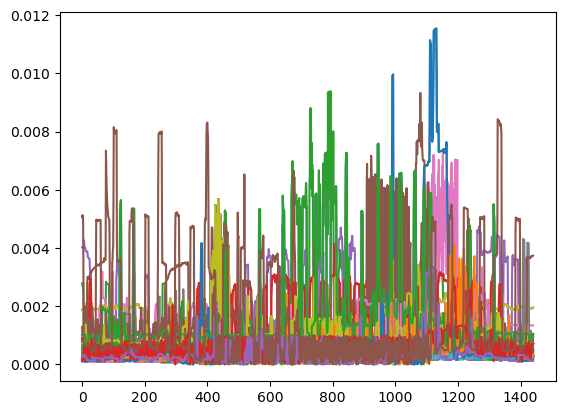

56-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005A582760>
 PyObject <matplotlib.lines.Line2D object at 0x000000005A582820>
 PyObject <matplotlib.lines.Line2D object at 0x000000005A5828E0>
 PyObject <matplotlib.lines.Line2D object at 0x000000005A5829A0>
 PyObject <matplotlib.lines.Line2D object at 0x000000005A582A60>
 PyObject <matplotlib.lines.Line2D object at 0x000000005A582B20>
 PyObject <matplotlib.lines.Line2D object at 0x000000005A582BE0>
 PyObject <matplotlib.lines.Line2D object at 0x000000005A582CA0>
 PyObject <matplotlib.lines.Line2D object at 0x000000005A582D60>
 PyObject <matplotlib.lines.Line2D object at 0x000000005A582E20>
 PyObject <matplotlib.lines.Line2D object at 0x000000006258E9A0>
 PyObject <matplotlib.lines.Line2D object at 0x000000005A582F70>
 PyObject <matplotlib.lines.Line2D object at 0x000000005A58C070>
 ⋮                                                              
 PyObject <matplotlib.lines.Line2D object at 0x000000

In [34]:
writedlm(string("House_",case_name,"_profile.csv"),house_prof, ',');
writedlm(string("PV_",case_name,"_profile.csv"),PV_prof, ',');
plot(house_prof')

In [52]:
## PARSE GENERATOR DATA
idx_gen = findall(idx_gen -> idx_gen == "PV" || idx_gen == "SWING" , bus_type)
global ngy_sl = length(idx_gen);

## Calculate PV inverter ratings
global ngy_inv = size(hload,1); global yinv_ph = bus_ph[Int.(hload[:,1])]
global idx_ygen = 1:ngy_inv; global yinv_par = bus_ID[Int.(hload[:,1])]
yinv_powerP = PV_sch[:,count_sch];
global yinv_ratedS = repeat([PV_rat],ngy_inv)
global ngy = ngy_sl + length(idx_ygen);

## Create ygen matrix
global ygen = zeros(ngy,20)
Smax = 100*baseMVA
Pg_min = zeros(ngy_sl,3); Pg_max = ones(ngy_sl,3)*Smax;
Qg_max = ones(ngy_sl,3)*Smax;
ygen[1:ngy_sl,1] = idx_gen
ygen[1:ngy_sl,2:4:13] = Pg_min
ygen[1:ngy_sl,3:4:14] = Pg_max
ygen[1:ngy_sl,4:4:15] = -Qg_max
ygen[1:ngy_sl,5:4:16] = Qg_max
ygen[1:ngy,20] .= 1
if length(idx_ygen) != 0
    Qmax = sqrt.(yinv_ratedS.^2 .- yinv_powerP.^2);
    if obj_op == 1 || obj_op == 6
        Qmax = zeros(ngy_inv);
    end
    Qmin = -Qmax; ygen[2:end,1] = hload[:,1];
    for i=1:length(idx_ygen)
        if occursin("A",yinv_ph[i])
            ygen[i+ngy_sl,2] = yinv_powerP[i];  ygen[i+ngy_sl,3] = yinv_powerP[i];
            ygen[i+ngy_sl,4] = Qmin[i];  ygen[i+ngy_sl,5] = Qmax[i];
        end
        if  occursin("B",yinv_ph[i])
            ygen[i+ngy_sl,6] = yinv_powerP[i];  ygen[i+ngy_sl,7] = yinv_powerP[i];
            ygen[i+ngy_sl,8] = Qmin[i];  ygen[i+ngy_sl,9] = Qmax[i];
    end
        if  occursin("C",yinv_ph[i])
            ygen[i+ngy_sl,10] = yinv_powerP[i];  ygen[i+ngy_sl,11] = yinv_powerP[i];
            ygen[i+ngy_sl,12] = Qmin[i];  ygen[i+ngy_sl,13] = Qmax[i];
        end
    end
end
global ngy_nph = Int(sum(bus_count[Int.(ygen[:,1])]))

## Create dgen matrix
global ngd = 0; global dgen = zeros(ngd,20)
global ngd_nph = 0; global ngdy_nph = 0;

384×20 Array{Float64,2}:
 263.0  0.0001812  0.0  0.0        …  0.00020385   0.0  0.0          1.0
 264.0  0.0001198  0.0  0.0           0.000134775  0.0  0.0          1.0
 267.0  0.00028    0.0  0.0           0.000315     0.0  0.0          1.0
 268.0  6.26e-5    0.0  0.0           7.0425e-5    0.0  0.0          1.0
 280.0  0.0001222  0.0  0.0           0.000137475  0.0  0.0          1.0
 281.0  0.0008838  0.0  0.0        …  0.000994275  0.0  0.0          1.0
 284.0  0.0004164  0.0  0.0           0.00046845   0.0  0.0          1.0
 287.0  7.6e-5     0.0  0.0           8.55e-5      0.0  0.0          1.0
 289.0  0.0004164  0.0  0.0           0.00046845   0.0  0.0          1.0
 290.0  7.02e-5    0.0  0.0           7.8975e-5    0.0  0.0          1.0
 293.0  3.46e-5    0.0  0.0        …  3.8925e-5    0.0  0.0          1.0
 302.0  4.92e-5    0.0  0.0           5.535e-5     0.0  0.0          1.0
 303.0  7.02e-5    0.0  0.0           7.8975e-5    0.0  0.0          1.0
   ⋮                      